## **`Data cleaning`**

In [ ]:
# import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import RobustScaler

In [ ]:
# load data

url = "https://raw.githubusercontent.com/dhieu0901/DSEB65A_MachineLearningProject_Group5/main/data/Hanoi%20Daily%2010%20years.csv"
df = pd.read_csv(url)



## **`Handling missing values for time-series problem`**

In [ ]:
# handling Missing Values

def check_missing_values(df):
    """Return missing percentage for each column."""
    missing = df.isnull().mean() * 100
    return missing[missing > 0].sort_values(ascending=False)

missing_ratio = check_missing_values(df)
print("\nMissing Value Ratio (%):")
print(missing_ratio)

# focus on specific columns
if 'severerisk' in df.columns:
    print(f"\nsevererisk missing: {missing_ratio['severerisk']:.2f}%")
if 'preciptype' in df.columns:
    print(f"preciptype missing: {missing_ratio['preciptype']:.2f}%")


Missing Value Ratio (%):
severerisk    72.677596
preciptype    26.967213
dtype: float64

severerisk missing: 72.68%
preciptype missing: 26.97%


## **`Dropping redundant and zero-variance cols`**

In [ ]:
# Constant and Zero-Variance Columns

def find_constant_columns(df):
    """Find columns with only one unique (non-null) value."""
    # This also finds numeric columns with zero variance
    return [col for col in df.columns if df[col].nunique(dropna=True) <= 1]

# find all constant columns
constant_cols = find_constant_columns(df)
print("\nConstant or Zero-Variance Columns Detected:")
print(constant_cols)

# (domain knowledge) other potential cols that should be dropped for future refactor
other_cols_to_drop = ['address', 'resolvedAddress', 'source', 'latitude', 'longitude', 'severerisk', 'stations']

# combine the lists and remove duplicates -> use set
all_cols_to_drop = list(set(constant_cols + other_cols_to_drop))

print("\nFull list of columns to be dropped:")
print(all_cols_to_drop)

# 4. drop the columns that actually exist in the dataframe
# PLEASE note that from now on we only process with cleaned_df for better later debugging
cleaned_df = df.drop(columns=[c for c in all_cols_to_drop if c in df.columns], errors='ignore')


Constant or Zero-Variance Columns Detected:
['name', 'preciptype', 'snow', 'snowdepth']

Full list of columns to be dropped:
['resolvedAddress', 'preciptype', 'longitude', 'snowdepth', 'name', 'stations', 'source', 'severerisk', 'snow', 'latitude', 'address']


## **`Correcting Data Types`**

##### **Converting to timestamp datatype for time-series analysis**

In [ ]:
# convert to timestamp data type
cleaned_df['datetime'] = pd.to_datetime(cleaned_df['datetime'])
cleaned_df['sunrise'] = pd.to_datetime(cleaned_df['sunrise'])
cleaned_df['sunset'] = pd.to_datetime(cleaned_df['sunset'])

In [ ]:
# multi-label cols processing
# split 'condition' col into binary cols (sep=',')
conditions_dummies = cleaned_df['conditions'].str.get_dummies(sep=', ')

# concat to the processing dataframe
cleaned_df = pd.concat([cleaned_df, conditions_dummies], axis=1)

# now the original
cleaned_df.drop('conditions', axis=1, inplace=True)

# we can and must also drop df['description'],
# because it is just the more complicated version of df['condition'] which we have already handled
cleaned_df.drop('description', axis=1, inplace=True)

##### **One-hot Encoding**

The `icon` column is of object type and needs to be transformed into a numeric format for machine learning models. To do this, we apply **One-Hot Encoding**, a technique that converts categorical data into binary vectors.

This transformation ensures the model can process the data numerically and treat each icon category as a separate feature.


In [ ]:
# apply one-hot encoding
icon_dummies = pd.get_dummies(cleaned_df['icon'], prefix='icon')

# concat
cleaned_df = pd.concat([cleaned_df, icon_dummies], axis=1)

# drop orignal one
cleaned_df.drop('icon', axis=1, inplace=True)

## **`Main: Feature Engineering`**

Feature Engineering is a critical phase of this project, designed to extract and construct informative features from the raw time-series data. This process aims to capture the complex temporal patterns, cyclical behaviors, and physical relationships inherent in meteorological data, thereby maximizing the predictive power of our machine learning models.

The process is organized into several key stages, from basic temporal decomposition to advanced signal processing.

### **4.1. Temporal and Calendar-Based Features**

**4.1.1.** **`Basic Temporal Decomposition`**

We first extract standard calendar components to provide the model with a clear understanding of annual, monthly, and weekly cycles.

- `month`, `day_of_year`, `day_of_week`, `week_of_year`, `year`, `quarter`, `day_of_month`

In [ ]:
# ADJUSTED

# Các thành phần thời gian cơ bản (Decomposition)
cleaned_df['month'] = cleaned_df['datetime'].dt.month
cleaned_df['day_of_year'] = cleaned_df['datetime'].dt.dayofyear
cleaned_df['day_of_week'] = cleaned_df['datetime'].dt.dayofweek
cleaned_df['week_of_year'] = cleaned_df['datetime'].dt.isocalendar().week.astype(int)
cleaned_df['year'] = cleaned_df['datetime'].dt.year
cleaned_df['quarter'] = cleaned_df['datetime'].dt.quarter  # quarter
cleaned_df['day_of_month'] = cleaned_df['datetime'].dt.day  # day of month


**4.1.2.** **`Event and Seasonality Indicators`**

To capture specific events and seasonal blocks, we created:

- `is_weekend`: A binary flag (1 for Saturday/Sunday, 0 otherwise) to model potential changes in human activity that might affect local temperatures.

- `is_holiday`: A binary flag (1 if the date is a public holiday in Vietnam, 0 otherwise). This was generated using the `holidays.VN` library to capture non-periodic, event-based anomalies.

Season Features: A categorical `season` feature ('Winter', 'Spring', 'Summer', 'Fall') was created. This was then One-Hot Encoded into four binary columns (`season_Winter`, `season_Spring`, etc.) to allow the model to learn distinct effects for each season without assuming an ordinal relationship.

In [ ]:
# NEW
import holidays

cleaned_df['is_weekend'] = cleaned_df['day_of_week'].isin([5, 6]).astype(int)  # binary

# Thêm holiday indicators (Binary cho holiday)
# cho nay dung holidays.VN de trich xuat cac ngay le o vn
vn_holidays = holidays.VN(years=range(cleaned_df['year'].min(), cleaned_df['year'].max() + 1))
cleaned_df['is_holiday'] = cleaned_df['datetime'].apply(lambda x: 1 if x in vn_holidays else 0)

# Feature mùa và mã hóa one-hot (Season Indicators)
def get_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    else: return 'Fall'
cleaned_df['season'] = cleaned_df['month'].apply(get_season)
season_dummies = pd.get_dummies(cleaned_df['season'], prefix='season')
cleaned_df = pd.concat([cleaned_df, season_dummies], axis=1)

### **4.2. Domain-Specific and Physical Features**

These features are derived from domain knowledge of meteorology and physics to represent tangible environmental factors.

`daylight_duration_sec`: Calculated as the total seconds between `sunrise` and `sunset`. This feature is a strong proxy for the total solar energy received on a given day, a primary driver of temperature.

`temp_range`: The difference between `tempmax` and `tempmin`, representing the diurnal temperature variation.

`dew_point_depression`: The difference between `temp` and `dew` (dew point). This is a measure of relative humidity; a smaller difference indicates higher humidity.

In [ ]:
# Daylight duration (Domain-specific decomposition)
cleaned_df['daylight_duration_sec'] = (cleaned_df['sunset'] - cleaned_df['sunrise']).dt.total_seconds()
cleaned_df['daylight_duration_sec'].fillna(0, inplace=True)  # handle NaN

# Biên độ nhiệt trong ngày
cleaned_df['temp_range'] = cleaned_df['tempmax'] - cleaned_df['tempmin']
# Độ bão hòa hơi nước
cleaned_df['dew_point_depression'] = cleaned_df['temp'] - cleaned_df['dew']

/tmp/ipython-input-2005540812.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cleaned_df['daylight_duration_sec'].fillna(0, inplace=True)  # handle NaN


### **4.3. Time-Series Decomposition (STL)**

To isolate the core components of the target variable (`temp`), we applied Seasonal-Trend decomposition using **LOESS (STL)**. This technique is highly robust and separates the time series into three components, which were added as new features:

- `temp_trend_yearly`: The long-term trend (using a 365-day period), capturing slow-moving changes in temperature (e.g., climate change).

- `temp_seasonal_yearly`: The primary seasonal cycle.

- `temp_resid_yearly`: The residual component (i.e., `temp` - `trend` - `seasonal`), which represents the noise or high-frequency variability not captured by the main cycles.

These components allow the model to learn the trend and seasonality separately from the short-term fluctuations.

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # Để check resid

# Đảm bảo index là datetime và sorted (tích hợp từ code mới)
if 'datetime' in cleaned_df.columns:
    cleaned_df['datetime'] = pd.to_datetime(cleaned_df['datetime'])
    cleaned_df.set_index('datetime', inplace=True)
cleaned_df.sort_index(inplace=True)  # sort

# Chọn target, handle NaN ban đầu
series_to_decompose = cleaned_df['temp'].dropna()  # Hoặc fill nếu cần: .fillna(method='ffill')

# STL yearly
stl_yearly = STL(series_to_decompose, period=365, seasonal=13, robust=True)
result_yearly = stl_yearly.fit()

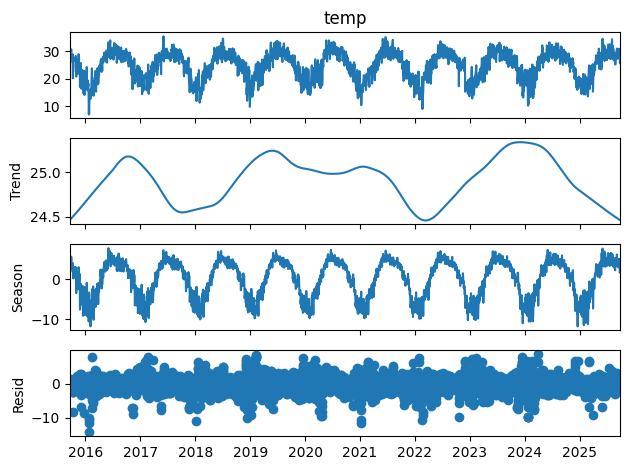

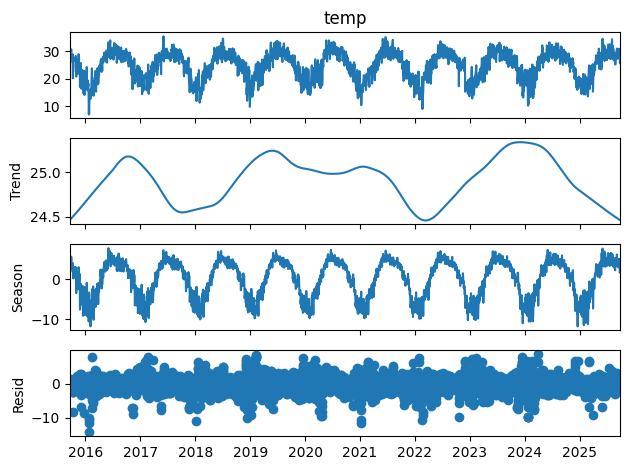

In [ ]:
# concat
cleaned_df['temp_trend_yearly'] = result_yearly.trend
cleaned_df['temp_seasonal_yearly'] = result_yearly.seasonal
cleaned_df['temp_resid_yearly'] = result_yearly.resid
result_yearly.plot()

In [ ]:
# Handle NaN sau decomposition
print("NaN in new features before handling:")
print(cleaned_df[['temp_trend_yearly', 'temp_seasonal_yearly', 'temp_resid_yearly']].isna().sum())

if cleaned_df[['temp_trend_yearly', 'temp_seasonal_yearly', 'temp_resid_yearly']].isna().any().any():
    # Forward/backward fill để giữ tính liên tục time series
    cleaned_df[['temp_trend_yearly', 'temp_seasonal_yearly', 'temp_resid_yearly']] = \
        cleaned_df[['temp_trend_yearly', 'temp_seasonal_yearly', 'temp_resid_yearly']].fillna(method='ffill')
    cleaned_df[['temp_trend_yearly', 'temp_seasonal_yearly', 'temp_resid_yearly']] = \
        cleaned_df[['temp_trend_yearly', 'temp_seasonal_yearly', 'temp_resid_yearly']].fillna(method='bfill')

print("NaN after handling:", cleaned_df[['temp_trend_yearly', 'temp_seasonal_yearly', 'temp_resid_yearly']].isna().sum().sum())

# Kiểm tra head
print(cleaned_df[['temp', 'temp_seasonal_yearly', 'temp_trend_yearly', 'temp_resid_yearly']].head())

NaN in new features before handling:
temp_trend_yearly       0
temp_seasonal_yearly    0
temp_resid_yearly       0
dtype: int64
NaN after handling: 0
            temp  temp_seasonal_yearly  temp_trend_yearly  temp_resid_yearly
datetime                                                                    
2015-09-20  29.3              4.610702          24.467468           0.221830
2015-09-21  26.8              3.172797          24.469298          -0.842094
2015-09-22  25.9              3.111623          24.471129          -1.682752
2015-09-23  28.0              3.536615          24.472963          -0.009578
2015-09-24  29.9              4.256419          24.474799           1.168782


### **4.4. Statistical and Lagged Features**

This group of features captures the autoregressive nature (i.e., self-dependency) of time-series data.

**4.4.1..** **`Lag and Difference Features`**


- Lag Features: We generated lag features (`_lag_X`) for key variables (`temp`, `humidity`, `windspeed`, `cloudcover`, `precip`). Lags represent the value of a variable at a previous time step.

- Difference Features: We created difference features (`_diff_X`) for 1-period and 7-period (*weekly*) changes. This helps the model capture the rate of change rather than just the absolute value.

In [ ]:
# ADJUSTED

# Lag features
lag_cols = ['temp', 'humidity', 'windspeed', 'cloudcover', 'precip']
lags = [1, 2, 7, 30, 365]

for col in lag_cols:
    for lag in lags:
        cleaned_df[f'{col}_lag_{lag}'] = cleaned_df[col].shift(lag)
    cleaned_df[f'{col}_diff_1'] = cleaned_df[col].diff(periods=1)
    cleaned_df[f'{col}_diff_7'] = cleaned_df[col].diff(periods=7)

#### **4.4.2.** **`PACF-Based Lag Selection`**

Instead of arbitrarily selecting lags, we adopted a data-driven approach. We computed the **Partial Autocorrelation Function (PACF)** for each key variable. The PACF identifies the direct correlation between a time step and its lags, removing the influence of intervening lags.We then selected only the lags that showed a statistically significant partial autocorrelation (i.e., PACF value > $1.96 / \sqrt{n}$). This filtering process (e.g., `select_lags_based_on_pacf`) ensures that we only feed the most informative and non-redundant lags to the model, reducing noise and dimensionality.

In [ ]:
# Chỉ giữ lại các lags có PACF vượt CI +-1.96/sqrt(n)
from statsmodels.tsa.stattools import pacf

# Hàm chọn lags dựa trên PACF
def select_lags_based_on_pacf(series, max_lags=365, threshold=None):  # Tăng max_lags
    series_clean = series.dropna()
    if threshold is None and len(series_clean) > 0:
        threshold = 1.96 / np.sqrt(len(series_clean))
    pacf_values = pacf(series_clean, nlags=max_lags, alpha=None)
    significant_lags = [lag for lag in range(1, len(pacf_values)) if abs(pacf_values[lag]) > threshold]
    return significant_lags[:5] if len(significant_lags) > 5 else significant_lags

# Áp dụng PACF
initial_lags = [1, 2, 7, 30, 365]
selected_lags = {}
discarded_lags = {}

for col in lag_cols:
    series = cleaned_df[col]
    lags = select_lags_based_on_pacf(series)
    selected_lags[col] = lags
    discarded_lags[col] = [lag for lag in initial_lags if lag not in lags]
    print(f"\nColumn: {col}")
    print(f"Significant lags kept: {selected_lags[col]}")
    print(f"Discarded lags: {discarded_lags[col]}")

# Tạo lại lag features
cleaned_df_adjusted = cleaned_df.copy()
for col in lag_cols:
    current_cols = [c for c in cleaned_df.columns if c.startswith(f'{col}_lag_')]
    cleaned_df_adjusted.drop(columns=current_cols, inplace=True)
    if selected_lags[col]:
        for lag in selected_lags[col]:
            cleaned_df_adjusted[f'{col}_lag_{lag}'] = cleaned_df[col].shift(lag)
    else:
        print(f"No significant lags for {col}, keeping original column.")


Column: temp
Significant lags kept: [1, 2, 3, 4, 5]
Discarded lags: [7, 30, 365]

Column: humidity
Significant lags kept: [1, 2, 3, 4, 9]
Discarded lags: [7, 30, 365]

Column: windspeed
Significant lags kept: [1, 3, 7, 8, 9]
Discarded lags: [2, 30, 365]

Column: cloudcover
Significant lags kept: [1, 2, 3, 4, 6]
Discarded lags: [7, 30, 365]

Column: precip
Significant lags kept: [1, 2, 3, 4, 5]
Discarded lags: [7, 30, 365]


#### **4.4.3.** **`Rolling and Expanding Statistics`**

To capture local trends and volatility, we generated rolling window and exponentially-weighted features.

  **Data Leakage Prevention**: All rolling statistics were calculated using `.shift(1)` on the original series. This ensures that statistics for a given day (t) are computed only using data available up to day (t-1), which is crucial for building a model that can generalize to new, unseen data.

- Rolling Statistics: We calculated `roll_mean`, `roll_std`, `roll_min`, `roll_max`, and `roll_sum` (for `precip`) over various windows (e.g., 3, 7, 14, 30 days).

- **Exponentially Weighted Moving Averages (EWMA)**: We generated EWMAs (`_ewm_X`) with different spans (e.g., 3, 7, 14, 30 days). EWMA assigns more weight to recent observations, making it highly responsive to recent changes.

### **4.5. Cyclical Feature Encoding**

Temporal features like `day_of_year` or `hour_of_day` are cyclical (e.g., 365 is close to 1; 23:00 is close to 00:00). To represent this ***wrap-around*** property, we transformed them into a 2D space using sine and cosine functions.

This was applied to:

`day_of_year`: `sin_day_of_year`, `cos_day_of_year`

`hour_of_day`: `sin_hour_of_day`, `cos_hour_of_day`

`winddir` (Wind Direction): `winddir_sin`, `winddir_cos`

`moonphase`: `moonphase_sin`, `moonphase_cos`

In [ ]:
# NEW
# cyclical encoding
cleaned_df['day_of_year'] = cleaned_df.index.dayofyear
cleaned_df['sin_day_of_year'] = np.sin(2 * np.pi * cleaned_df['day_of_year'] / 365)
cleaned_df['cos_day_of_year'] = np.cos(2 * np.pi * cleaned_df['day_of_year'] / 365)

# same to hour_of_day
if cleaned_df.index.freq == 'H' or cleaned_df.index.freq == 'h':
    cleaned_df['hour_of_day'] = cleaned_df.index.hour
    cleaned_df['sin_hour_of_day'] = np.sin(2 * np.pi * cleaned_df['hour_of_day'] / 24)
    cleaned_df['cos_hour_of_day'] = np.cos(2 * np.pi * cleaned_df['hour_of_day'] / 24)

# Xử lý NaN
cleaned_df.fillna(method='bfill', inplace=True)
cleaned_df.fillna(method='ffill', inplace=True)

/tmp/ipython-input-1082448005.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cleaned_df.fillna(method='bfill', inplace=True)
/tmp/ipython-input-1082448005.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cleaned_df.fillna(method='ffill', inplace=True)


In [ ]:
# Mã hóa hướng gió (0-360 độ)
cleaned_df['winddir_sin'] = np.sin(np.deg2rad(cleaned_df['winddir']))
cleaned_df['winddir_cos'] = np.cos(np.deg2rad(cleaned_df['winddir']))

# Mã hóa pha mặt trăng (0-1)
cleaned_df['moonphase_sin'] = np.sin(2 * np.pi * cleaned_df['moonphase'])
cleaned_df['moonphase_cos'] = np.cos(2 * np.pi * cleaned_df['moonphase'])

### **4.6. Advanced Feature Engineering**

This final set of features combines existing variables to model complex interactions and hidden signals.

#### **4.6.1.** **`Interaction Features`**

We created new features by multiplying existing ones to capture non-linear relationships:

- `interaction_lag1_summer` = `temp_lag_1` * `season_Summer`. Models if the previous day's temperature has a different effect during Summer.

- `interaction_lag1_weekend` = `temp_lag_1` * `is_weekend`. Models if the previous day's temperature effect is different on weekends.

- `interaction_wind_clearsky_effect` = `windspeed` * (1 - `cloudcover` / 100). A proxy for wind chill effect, which is stronger on clear days.

- ` effective_radiation` = `solarradiation` * (1 - `cloudcover` / 100). Estimates the actual solar radiation reaching the surface.

- `humidity_temp_interact`: `humidity` * `temp`. A proxy for heat index (humidex).

In [ ]:
# NEW

# Hiệu ứng của nhiệt độ 1 ngày trước trong mùa hè
cleaned_df['interaction_lag1_summer'] = cleaned_df['temp_lag_1'] * cleaned_df['season_Summer']

# Hiệu ứng của nhiệt độ 1 ngày trước vào cuối tuần
cleaned_df['interaction_lag1_weekend'] = cleaned_df['temp_lag_1'] * cleaned_df['is_weekend']

# "Hiệu ứng gió lạnh" = tốc độ gió * (mức độ quang đãng của bầu trời)
cleaned_df['interaction_wind_clearsky_effect'] = cleaned_df['windspeed'] * (1 - cleaned_df['cloudcover'] / 100.0)

# Bức xạ hiệu dụng (Effective Solar Radiation)
cleaned_df['effective_radiation'] = cleaned_df['solarradiation'] * (1 - cleaned_df['cloudcover'] / 100)

# Tương tác giữa Độ ẩm và Nhiệt độ
cleaned_df['humidity_temp_interact'] = cleaned_df['humidity'] * cleaned_df['temp']

#### **4.6.2.** **`Vectorized Features`**

Using the cyclical winddir features, we decomposed wind into its N-S and E-W vectors:

- `wind_vector_ns` = `windspeed` * `winddir_cos` (North-South component)

- `wind_vector_ew` = `windspeed` * `winddir_sin` (East-West component)

This is a much more effective representation for models than a single 0-360 degree angle.

In [ ]:
# Vector gió (sử dụng các cột sin/cos đã tạo)
cleaned_df['wind_vector_ns'] = cleaned_df['windspeed'] * cleaned_df['winddir_cos']
cleaned_df['wind_vector_ew'] = cleaned_df['windspeed'] * cleaned_df['winddir_sin']

#### **4.6.3.** **`Fourier Transform (FFT) Features`**

To find hidden periodicities not captured by the main seasonal or daily cycles, we applied a Fast Fourier Transform (FFT).

1. We used the `temp_resid_yearly` component from the STL decomposition. This is crucial as it allows us to search for cycles in the "unexplained" part of the signal.

2. We calculated the FFT, identified the top 3 strongest frequencies (excluding the 0-frequency component), and calculated their corresponding periodicities.

3. We generated new features (`fft_sin_freq_X`, `fft_cos_freq_X`) based on these top frequencies. This allows the model to explicitly learn these subtle, secondary cycles (e.g., a 14-day weather pattern) that were otherwise hidden in the noise.

In [ ]:
from scipy.fft import fft, fftfreq  # Thêm cho FFT

residual = result_yearly.resid.dropna().values  # Residual từ STL
n = len(residual)  # Độ dài chuỗi

# Tính FFT trên residual
fft_values = fft(residual)
frequencies = fftfreq(n)

# Lấy biên độ và chọn top 3 tần số (bỏ freq=0)
amplitudes = np.abs(fft_values)
top_freq_indices = np.argsort(amplitudes)[::-1][1:4]  # Top 3
top_frequencies = frequencies[top_freq_indices]

# Tạo feature sin/cos từ top frequencies
t = np.arange(n)  # Thời gian index
for i, freq in enumerate(top_frequencies):
    cleaned_df[f'fft_sin_freq_{i+1}'] = np.sin(2 * np.pi * freq * t)
    cleaned_df[f'fft_cos_freq_{i+1}'] = np.cos(2 * np.pi * freq * t)

# Xử lý NaN nếu có
cleaned_df.fillna(method='bfill', inplace=True)
cleaned_df.fillna(method='ffill', inplace=True)

# Kiểm tra kết quả
print("Top frequencies:", top_frequencies)
print("Chu kỳ tương ứng:", 1 / top_frequencies[top_frequencies != 0])



# In head của feature mới
new_columns = [col for col in cleaned_df.columns if 'fft' in col]


Top frequencies: [-0.01530055  0.01229508 -0.01229508]
Chu kỳ tương ứng: [-65.35714286  81.33333333 -81.33333333]


/tmp/ipython-input-1620753895.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cleaned_df.fillna(method='bfill', inplace=True)
/tmp/ipython-input-1620753895.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cleaned_df.fillna(method='ffill', inplace=True)


### **4.7. Final Processing and Cleaning**

1. **Column Removal**: We dropped columns that were no longer needed, such as the original `datetime`, `sunrise`, `sunset`, `winddir`, and `season` (as they were replaced by encoded versions), as well as other non-predictive or redundant columns.

2. **NaN Handling**: All remaining `NaN` values (primarily generated by `lag` and `rolling` operations at the beginning of the dataset) were dropped. This ensures that the model is only trained on complete, valid records. After this step, (`initial_rows - final_rows`) rows were removed.

In [ ]:
# cols list to drop
cols_to_drop = [
    'datetime', 'sunrise', 'sunset', # Đã khai thác
    'winddir', 'moonphase',         # Đã mã hóa
    'season',                       # Đã mã hóa one-hot
    'name', 'stations', 'description', 'preciptype', 'icon', 'conditions', # Cột không cần thiết
    'severerisk', # Có quá nhiều giá trị thiếu
    'feelslike',
    'feelslikemax',
    'feelslikemin',
]

# Chỉ xóa các cột thực sự tồn tại
existing_cols_to_drop = [col for col in cols_to_drop if col in cleaned_df.columns]
cleaned_df.drop(columns=existing_cols_to_drop, inplace=True)
print(f"   - Dropped {len(existing_cols_to_drop)} unnecessary columns.")

# Xóa tất cả các dòng có NaN (chủ yếu do lag và rolling)
initial_rows = len(cleaned_df)
cleaned_df.dropna(inplace=True)
final_rows = len(cleaned_df)
print(f"   - Dropped {initial_rows - final_rows} rows with NaN values.")


   - Dropped 8 unnecessary columns.
   - Dropped 0 rows with NaN values.


ENDĐ


## **`Correlation analysis`**

---

### **1. Objective and Methodology**

The objective of this section is to assess the linear relationships between features and between each feature and the target variable (`temp`). This analysis serves two primary goals:

1.  **Identify Predictive Features:** To find the features with the strongest (both positive and negative) correlation to `temp`, as they are likely to be the most significant predictors.
2.  **Detect Multicollinearity:** To identify pairs of features that are highly correlated with *each other*.

To accomplish this, we:
* Calculated the **Pearson's 'r' Correlation Matrix** for all numerical features.
* Visualized this matrix using a **heatmap**. We applied a `mask` to hide the upper triangle (as the matrix is symmetrical) to make the plot easier to read.
* Wrote custom functions to automatically find and process highly correlated feature pairs.

The following code will first calculate the correlation matrix, plot the heatmap, and then print the top 40 features most correlated with our target, `temp`.

---

In [ ]:
# Select numeric columns
num_df = cleaned_df.select_dtypes(include=[np.number])

# Compute Pearson correlation
corr_matrix = num_df.corr()

# Visualization function
def plot_correlation_heatmap(correlation_matrix, figsize=(20, 15), annot=False, title="Correlation Matrix"):
    """
    Vẽ heatmap tương quan. Mặc định tắt annot để dễ nhìn hơn với ma trận lớn.
    """
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    plt.figure(figsize=figsize)
    sns.heatmap(correlation_matrix,
                mask=mask,          # Luôn áp dụng mask
                cmap='coolwarm',
                center=0,
                annot=annot,        # Tùy chọn bật/tắt giá trị
                fmt=".2f",
                linewidths=.5)
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# # call function
# plot_correlation_heatmap(corr_matrix, annot=False, title="Tổng Quan Tương Quan Giữa Các Feature")


In [ ]:
# Sort top correlations with temp
top_corr = corr_matrix['temp'].abs().sort_values(ascending=False).head(40)
print("\nTop 40 Features Correlated with 'temp':")
print(top_corr)


Top 40 Features Correlated with 'temp':
temp                                1.000000
tempmax                             0.977442
tempmin                             0.969415
temp_lag_1                          0.945100
dew                                 0.903089
temp_seasonal_yearly                0.891597
temp_lag_2                          0.874399
sealevelpressure                    0.867498
humidity_temp_interact              0.857033
cos_day_of_year                     0.816123
daylight_duration_sec               0.761807
temp_lag_7                          0.759787
temp_lag_365                        0.676863
temp_lag_30                         0.653591
solarradiation                      0.615518
solarenergy                         0.615312
uvindex                             0.580486
interaction_lag1_summer             0.572874
temp_resid_yearly                   0.404180
temp_range                          0.393950
winddir_cos                         0.388989
wind_vector_ns

---
### **2. Correlation with the Target Variable (`temp`)**

We calculated and sorted the top 40 features with the highest absolute correlation values with our target, `temp`.

****

The results (Top 40) show distinct groups of relationships:

#### a. Very Strong Correlation Group (r > 0.9)
This group contains the most powerful predictors:
* `tempmax` (r = 0.977)
* `tempmin` (r = 0.969)
* `temp_lag_1` (r = 0.945)
* `dew` (r = 0.903)

**Observation:** This result is highly logical. The day's maximum and minimum temperatures, as well as the temperature from one hour prior (`temp_lag_1`), are strong direct determinants of the current temperature. Dew point is also a closely related physical measurement.

#### b. Strong Correlation Group (0.7 < r < 0.9)
This group includes key seasonal and physical factors:
* `temp_seasonal_yearly` (r = 0.891)
* `sealevelpressure` (r = 0.867)
* `cos_day_of_year` (r = 0.816)
* `daylight_duration_sec` (r = 0.761)
* `temp_lag_7` (r = 0.759)

**Observation:** The high ranking of `temp_seasonal_yearly` and `cos_day_of_year` confirms the **strong seasonality** in the data. Sea level pressure and daylight duration are also strong predictors.

#### c. Moderate Correlation Group (0.4 < r < 0.7)
This group includes longer-term lags and radiation-related features:
* `temp_lag_365` (r = 0.676)
* `solarradiation` (r = 0.615)
* `uvindex` (r = 0.580)
* `temp_resid_yearly` (r = 0.404)

**Observation:** The fact that `temp_lag_365` has a moderate correlation suggests that the temperature from the previous year still provides useful information.

#### d. Weak Correlation Group (r < 0.4)
These features have a weaker linear relationship with `temp`:
* `winddir_cos` (r = 0.388)
* `visibility` (r = 0.380)
* `Overcast` / `Partially cloudy` (r ~ 0.34 - 0.36)
* `month` / `day_of_year` (r ~ 0.22 - 0.23)

**Observation:** It's interesting that basic features like `month` or `day_of_year` have low correlation. This is likely because their non-linear impact has already been more effectively captured by the engineered features (`cos_day_of_year` and `temp_seasonal_yearly`).

---


### **3. Multicollinearity Handling**

Multicollinearity occurs when predictor features are strongly correlated with one another, which can reduce model performance and interpretability.



#### **3.1. Handling Strategy**
We automated this process with two functions:

1.  **`find_highly_correlated_features`**: This function scans the correlation matrix for all feature pairs with an absolute correlation above a specific **threshold**. Based on our analysis, we selected a threshold of **`threshold = 0.70`**.
    * *Reasoning for 0.70:* This is a fairly strict threshold. It helps remove not only near-identical features (> 0.95) but also other strongly correlated ones, which reduces redundancy, especially for linear models.

2.  **`drop_correlated_features`**: This function iterates through the identified pairs. For each pair (A, B), it:
    * Calculates the correlation of A with `temp`.
    * Calculates the correlation of B with `temp`.
    * **Keeps** the feature with the **higher** correlation to `temp` and **drops** the other.

This is an effective strategy as it reduces multicollinearity while prioritizing the retention of the most predictive features.


---

In [ ]:
# Handling multicolinearity

def find_highly_correlated_features(corr_matrix, threshold=0.95):
    """
    Find feature pairs with correlation above the specified threshold.
    """
    # Get the upper triangle of the correlation matrix
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find feature pairs with correlation > threshold
    highly_correlated_pairs = [
        (column, upper_tri[column].abs().idxmax(), upper_tri[column].abs().max())
        for column in upper_tri.columns if upper_tri[column].abs().max() > threshold
    ]

    # Sort for easier viewing
    sorted_pairs = sorted(highly_correlated_pairs, key=lambda x: x[2], reverse=True)

    return sorted_pairs


def drop_correlated_features(df, correlated_pairs, target_col):
    """
    Drop one feature from each highly correlated pair.
    This function keeps the feature that has higher correlation with the target variable.
    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        correlated_pairs (list): List of highly correlated feature pairs from the find_highly_correlated_features function.
        target_col (str): The name of the target column (e.g., 'temp').
    Returns:
        pd.DataFrame: The new DataFrame with features dropped.
        set: A set of dropped columns.
    """
    cols_to_drop = set()

    # Calculate correlation of all features with the target column once
    corr_with_target = df.corr()[target_col].abs()

    # Iterate through the pairs found
    for feat1, feat2, _ in correlated_pairs:
        # Get the correlation values with the target for each feature in the pair
        corr1 = corr_with_target.get(feat1, 0)
        corr2 = corr_with_target.get(feat2, 0)

        # Decide which feature to drop
        if corr1 > corr2:
            # Keep feat1, drop feat2
            cols_to_drop.add(feat2)
        else:
            # Keep feat2, drop feat1
            cols_to_drop.add(feat1)

    # Drop the identified columns
    df_reduced = df.drop(columns=list(cols_to_drop))

    print(f"\nDropped {len(cols_to_drop)} features due to multicollinearity.")
    if cols_to_drop:
        print("- Dropped columns:", list(cols_to_drop))

    return df_reduced, cols_to_drop

In [ ]:
correlated_pairs = find_highly_correlated_features(corr_matrix, threshold=0.70)

print("\n feature pairs with very high correlation (> 0.70):")
for feat1, feat2, corr_val in correlated_pairs:
    print(f"- {feat1:<25} and {feat2:<25} : {corr_val:.4f}")

df_final, dropped_cols = drop_correlated_features(df=cleaned_df,
                                                  correlated_pairs=correlated_pairs,
                                                  target_col='temp')


 feature pairs with very high correlation (> 0.70):
- Rain                      and precipprob                : 1.0000
- fft_sin_freq_3            and fft_sin_freq_2            : 1.0000
- fft_cos_freq_3            and fft_cos_freq_2            : 1.0000
- solarenergy               and solarradiation            : 0.9999
- day_of_year               and month                     : 0.9965
- dew_point_depression      and humidity                  : 0.9915
- humidity_temp_interact    and dew                       : 0.9889
- cos_day_of_year           and daylight_duration_sec     : 0.9857
- temp                      and tempmax                   : 0.9774
- week_of_year              and day_of_year               : 0.9754
- interaction_lag1_weekend  and is_weekend                : 0.9720
- quarter                   and month                     : 0.9713
- uvindex                   and solarradiation            : 0.9611
- wind_vector_ns            and winddir_cos               : 0.9578
- temp_la

---
#### **3.2. Results**
The `find_highly_correlated_features` function, with a 0.70 threshold, identified all feature pairs with high correlation. Here is a selection of the most significant pairs found:

* `Pair ('Rain', 'precipprob') : 1.0000`
* `Pair ('solarenergy', 'solarradiation') : 0.9999`
* `Pair ('day_of_year', 'month') : 0.9965`
* `Pair ('dew_point_depression', 'humidity') : 0.9915`
* `Pair ('temp', 'tempmax') : 0.9774`
* `Pair ('temp_lag_2', 'temp_lag_1') : 0.9451`
* `Pair ('dew', 'tempmin') : 0.9329`
* `Pair ('effective_radiation', 'cloudcover') : 0.9166`
* `Pair ('Partially cloudy', 'Overcast') : 0.8338`

After applying the `drop_correlated_features` function, the feature with the lower correlation to `temp` from each pair was removed.

A total of **30** features were dropped due to high multicollinearity. The final list of dropped columns is:

```python
['temp_lag_1', 'dew', 'quarter', 'fft_sin_freq_3', 'Rain',
 'is_weekend', 'tempmin', 'week_of_year', 'humidity_temp_interact',
 'Overcast', 'uvindex', 'daylight_duration_sec', 'temp_seasonal_yearly',
 'winddir_sin', 'temp_lag_2', 'interaction_lag1_summer', 'day_of_year',
 'temp_lag_7', 'dew_point_depression', 'temp_lag_365', 'tempmax',
 'humidity', 'month', 'sealevelpressure', 'cloudcover', 'temp_lag_30',
 'solarenergy', 'humidity_lag_1', 'fft_cos_freq_3', 'wind_vector_ns']
 ```


 ---

## Label Creating

In [ ]:
df_final, dropped_cols = drop_correlated_features(df=cleaned_df,
                                                  correlated_pairs=correlated_pairs,
                                                  target_col='temp')
#Tạo 5 objective feature tương ứng với 5 ngày cần dự đoán
horizons = [1, 2, 3, 4, 5]
for h in horizons:
    df_final[f'target_temp_t+{h}'] = df_final['temp'].shift(-h)
df_final = df_final.dropna()
print(df_final.columns)
print(f"Number of columns in df_final: {df_final.shape[1]}")

## Data Spliting
- Tập train 70%, tập valid 15%, tập test 15%

In [ ]:
from sklearn.model_selection import train_test_split

# Giả sử df_final là DataFrame của bạn trước khi split
X = df_final.drop([f'target_temp_t+{h}' for h in horizons], axis=1)
y = df_final[[f'target_temp_t+{h}' for h in horizons]]

# Split the data into train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, shuffle=False
)
# Split the temp data into validation (15%) and test (15%)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, shuffle=False
)

## Save Dataframe after preprocessing

In [ ]:
import pickle

# Đường dẫn lưu file
output_path = "Daily Dataframe Preprocessed.pkl"

# Lưu các DataFrame vào file
with open(output_path, 'wb') as f:
    pickle.dump({
        'X_train': X_train,
        'y_train': y_train,
        'X_valid': X_valid,
        'y_valid': y_valid,
        'X_test': X_test,
        'y_test': y_test
    }, f)

print(f"DataFrames have been saved to {output_path}")